In [1]:
import atommover
import atommover.utils as movr
import atommover.algorithms as algos

import numpy as np

In [4]:
algorithms = [algos.BCv2()]
target_configs = [movr.Configurations.MIDDLE_FILL]
# sizes = [18]
sizes = np.array([10, 14, 18, 22, 26, 30])
shots = 100
bench = movr.Benchmarking(algorithms,target_configs,sys_sizes=sizes, n_shots=shots, n_species=1)

In [5]:
bench.run()

size 10 completed
size 14 completed
size 18 completed
size 22 completed
size 26 completed
size 30 completed


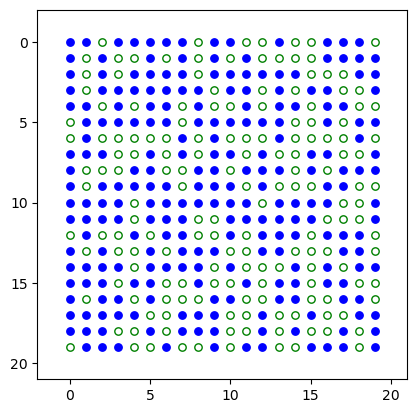

In [2]:
bad_init_config = np.load('problematic1.npy')
array = movr.AtomArray([20,20])
array.matrix = bad_init_config
array.generate_target(movr.Configurations.MIDDLE_FILL, occupation_prob=0.6)
array.image()
# array.plot_target_config()

True


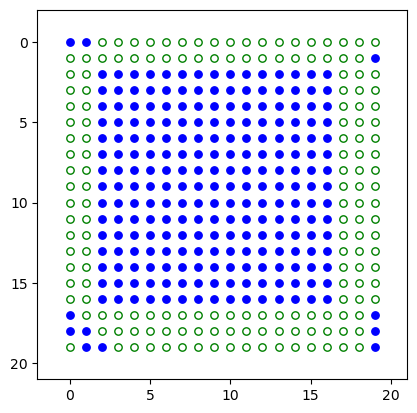

[[[(1, 2) -> (2, 3)]], [[(0, 7) -> (1, 8)], [(1, 8) -> (2, 8)]], [[(1, 16) -> (2, 15)]], [[(1, 17) -> (2, 16)]], [[(2, 9) -> (3, 9)], [(1, 9) -> (2, 9)]], [[(2, 12) -> (3, 12)], [(0, 13) -> (1, 12)], [(1, 12) -> (2, 12)]], [[(2, 15) -> (3, 14)], [(0, 17) -> (1, 16)], [(1, 16) -> (2, 15)]], [[(4, 1) -> (4, 2)], [(3, 0) -> (4, 1)]], [[(4, 3) -> (4, 4)], [(3, 2) -> (4, 3)], [(1, 0) -> (2, 1)], [(2, 1) -> (3, 2)]], [[(3, 7) -> (4, 7)], [(2, 7) -> (3, 7)], [(0, 5) -> (1, 6)], [(1, 6) -> (2, 7)]], [[(3, 9) -> (4, 9)], [(2, 8) -> (3, 9)], [(1, 7) -> (2, 8)]], [[(3, 10) -> (4, 10)], [(2, 10) -> (3, 10)], [(0, 10) -> (1, 10)], [(1, 10) -> (2, 10)]], [[(3, 13) -> (4, 12)], [(2, 14) -> (3, 13)], [(0, 16) -> (1, 15)], [(1, 15) -> (2, 14)]], [[(4, 16) -> (4, 15)], [(2, 18) -> (3, 17)], [(3, 17) -> (4, 16)]], [[(4, 7) -> (5, 7)], [(3, 7) -> (4, 7)], [(2, 6) -> (3, 7)], [(1, 5) -> (2, 6)]], [[(5, 16) -> (5, 15)], [(5, 15) -> (5, 14)], [(4, 17) -> (5, 16)], [(2, 19) -> (3, 18)], [(3, 18) -> (4, 17)]],

In [3]:
algo = algos.Hungarian()
final_config, move_set, success_flag = algo.get_moves(array)
print(success_flag)
array.matrix = final_config
array.image()
print(move_set)
### Note: problem is that atoms can't be moved up (either this routine fails or the function which decides whether to move atoms from bottom or top is flawed)

In [ ]:
_ = array.evaluate_moves(move_set)
array.image()

In [6]:
bench.benchmarking_results

<xarray.Dataset> Size: 376B
Dimensions:           (algorithm: 1, target: 1, sys size: 6, error model: 1,
                       physical params: 1, num rounds: 1)
Coordinates:
  * algorithm         (algorithm) object 8B Balance & Compact
  * target            (target) int64 8B 3
  * sys size          (sys size) int64 48B 10 14 18 22 26 30
  * error model       (error model) object 8B ZeroNoise
  * physical params   (physical params) object 8B <atommover.utils.core.Physi...
  * num rounds        (num rounds) int64 8B 1
Data variables:
    success rate      (algorithm, target, sys size, error model, physical params, num rounds) float64 48B ...
    time              (algorithm, target, sys size, error model, physical params, num rounds) float64 48B ...
    filling fraction  (algorithm, target, sys size, error model, physical params, num rounds) object 48B ...
    wrong places      (algorithm, target, sys size, error model, physical params, num rounds) object 48B ...
    n atoms           (algorithm, target, sys size, error model, physical params, num rounds) object 48B ...
    n targets         (algorithm, target, sys size, error model, physical params, num rounds) object 48B ...

In [10]:
import pickle
with open('data/scaling_bcnew_250605.pkl', 'wb') as file: 
    pickle.dump(bench.benchmarking_results,file)

In [11]:
with open('data/scaling_bcnew_250605.pkl', 'rb') as file: 
    adfss = pickle.load(file)

[1.06360271 0.02475139]


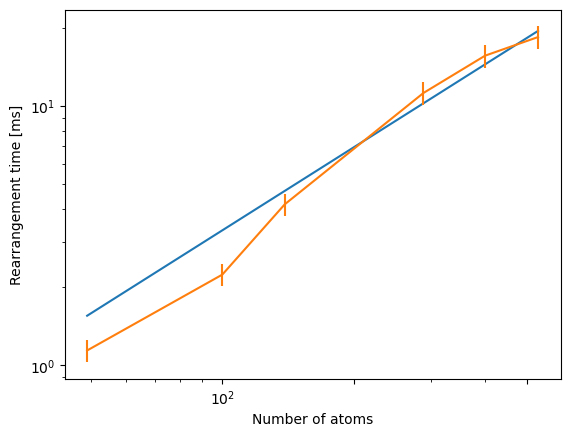

In [12]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def pwlaw(x,b,c):
    return c*((x)**b)

newbc = bench.benchmarking_results['time'].to_numpy()[0,0,:,0,0,0]*1e3
n_atoms = [49,100,139,289,400,529]
x_axis = np.linspace(np.min(n_atoms), np.max(n_atoms), 100)

poptparh, pcovparh = curve_fit(pwlaw, n_atoms, newbc, p0 =[1.1, 0.01], maxfev = 1000000)
perrparh = np.sqrt(np.diag(pcovparh))
plt.plot(x_axis, pwlaw(x_axis, *poptparh))
plt.errorbar(n_atoms, newbc,  yerr=1/np.sqrt(100)*newbc)
plt.yscale('log')
plt.xscale('log')
plt.xticks([100, 200, 500])
# plt.xticklabels([r'$10^{2}$', r'$2\times 10^{2}$', r'$5\times 10^{2}$'],fontsize = text_size)
plt.ylabel('Rearrangement time [ms]')
plt.xlabel('Number of atoms')
print(poptparh)

Hungarian - BC comparison figure

In [ ]:
tweezer_errors = np.logspace(-4, -2.5, 30)[::-1]
vac_lifetimes = np.logspace(-1.2, 1, 30)
err_models = []
for tw_err in tweezer_errors:
    for vac_l in vac_lifetimes:
        errmol = movr.UniformVacuumTweezerError(putdown_fail_rate=tw_err, lifetime=vac_l, pickup_fail_rate=0)
        err_models.append(errmol)
print(err_models[0].putdown_fail_rate, err_models[0].lifetime)

0.0031622776601683794 0.06309573444801933


In [93]:
# single species
algorithms = [algos.Hungarian(),algos.BCv2()]
sizes = [14]
n_shots = 1000
target_configs = [movr.Configurations.MIDDLE_FILL]
bench = movr.Benchmarking(algorithms,
                     sys_sizes=sizes,
                     target_configs=target_configs,
                     error_models_list = err_models,
                     n_shots=n_shots,
                     n_species = 1)
bench.run()

size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 completed
size 14 co

In [94]:
bench.benchmarking_results

<xarray.Dataset> Size: 94kB
Dimensions:           (algorithm: 2, target: 1, sys size: 1, error model: 900,
                       physical params: 1, num rounds: 1)
Coordinates:
  * algorithm         (algorithm) object 16B Hungarian Balance & Compact
  * target            (target) int64 8B 3
  * sys size          (sys size) int64 8B 14
  * error model       (error model) object 7kB UniformVacuumTweezerError ... ...
  * physical params   (physical params) object 8B <atommover.utils.core.Physi...
  * num rounds        (num rounds) int64 8B 1
Data variables:
    success rate      (algorithm, target, sys size, error model, physical params, num rounds) float64 14kB ...
    time              (algorithm, target, sys size, error model, physical params, num rounds) float64 14kB ...
    filling fraction  (algorithm, target, sys size, error model, physical params, num rounds) object 14kB ...
    wrong places      (algorithm, target, sys size, error model, physical params, num rounds) object 14kB ...
    n atoms           (algorithm, target, sys size, error model, physical params, num rounds) object 14kB ...
    n targets         (algorithm, target, sys size, error model, physical params, num rounds) object 14kB ...

(1, 1, 900, 1, 1)


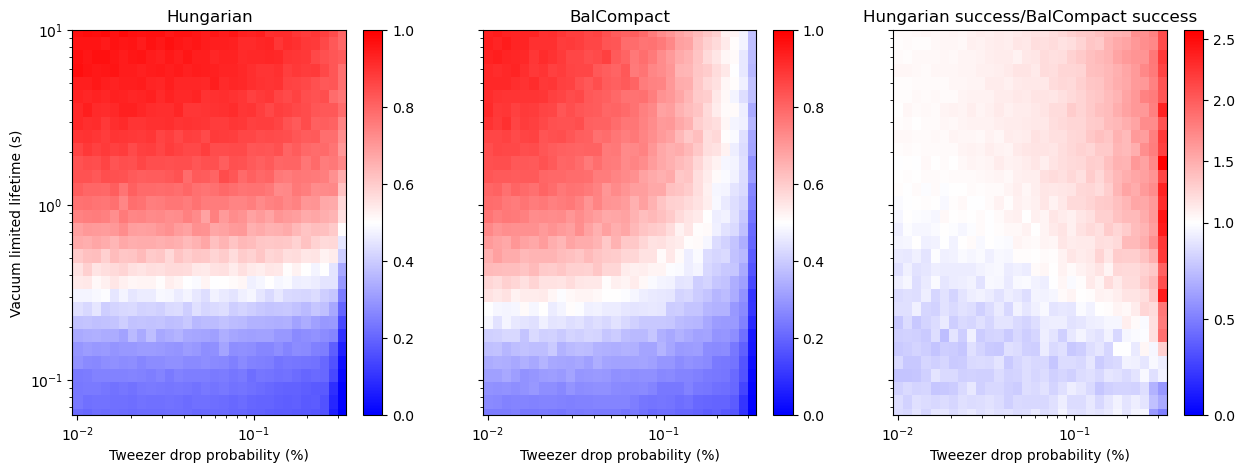

In [95]:
successes = bench.benchmarking_results['success rate'].to_numpy()
print(np.shape(successes[0]))
successes[0]

rates = bench.benchmarking_results['success rate'].to_numpy()[1,0,0,:,0,0]
rates, len(rates)

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.array(tweezer_errors)*100, np.array(vac_lifetimes))
fig, ax = plt.subplots(1,3, sharex =True, sharey=True, figsize = (15, 5))
rates_arr = bench.benchmarking_results['success rate'].to_numpy()[:,0,0,:,0,0]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"])

for i in range(len(algorithms)+1):

    try:
        rates = rates_arr[i,:]
    except IndexError:
        rates = np.zeros_like(rates_arr[0,:]).reshape(len(vac_lifetimes), len(tweezer_errors))
        for mi in range(len(rates)):
            for mj in range(len(rates[0])):
                options = rates_arr[:,mi*len(tweezer_errors)+mj]
                rates[mi,mj] = options[0]/options[1]
    Z = rates.reshape(len(tweezer_errors),len(vac_lifetimes)).T
    if i == 2:
        vcenter = 1
        vmax = Z.max()
    else:
        vcenter = 0.5
        vmax = 1

    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=vcenter, vmax=vmax)
    im = ax[i].pcolor(X,Y, Z, cmap=cmap, norm=norm)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim([np.min(vac_lifetimes), np.max(vac_lifetimes)])
    ax[i].set_xlabel("Tweezer drop probability (%)")
    if i == 2:
        # Normalize so that 1 is at the center
        cbar = plt.colorbar(im, ax=ax[i], cmap=cmap, norm=norm)
        ax[i].set_title('Hungarian success/BalCompact success')

    elif i==0:
        ax[i].set_ylabel("Vacuum limited lifetime (s)")
        ax[i].set_title('Hungarian')
        cbar = plt.colorbar(im, ax=ax[i])
    elif i==1:
        ax[i].set_title('BalCompact')
        cbar = plt.colorbar(im, ax=ax[i])

plt.show()

Text(0, 0.5, '$r_{H} / r_{BC}$')

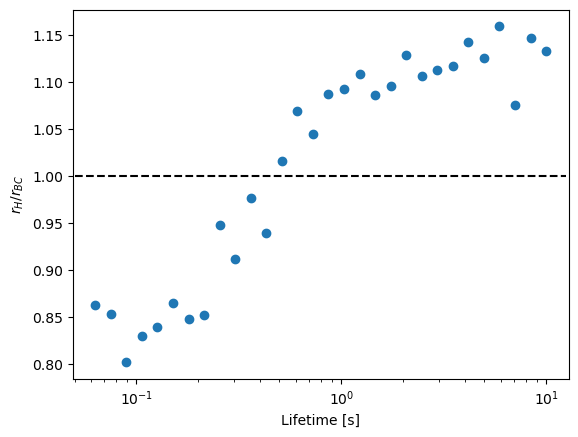

In [114]:
fig, ax = plt.subplots()
ax.scatter(np.array(vac_lifetimes),rates[16,:])
ax.set_xscale('log')
ax.hlines(1, xmin = min(vac_lifetimes)*0.8, xmax = max(vac_lifetimes)*1.25, color = 'k', ls = '--')
ax.set_xlabel('Lifetime [s]')
ax.set_ylabel(r'$r_{H} / r_{BC}$')